In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
from __future__ import division
import os
import urllib, cStringIO

import pymongo as pm
from PIL import Image
import base64

import numpy as np
from numpy import *
import os
import PIL
from PIL import Image
import base64
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches


import cStringIO
import pandas as pd
import pymongo as pm ## first establish ssh tunnel to server where database is running
from matplotlib.path import Path
import matplotlib.patches as patches
from svgpathtools import parse_path

In [2]:
# directory & file hierarchy
exp_path = 'bingstation'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [5]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
experiment_name = "Bingrun_v1"
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db[experiment_name]


In [6]:
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. 
valid_sessions = coll.find().distinct('sessionId')
practice_categories = ['square','shape','this circle']
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)

We currently have 129 valid sessions from Bingrun_v1.


#### helper functions for svg rendering

In [7]:
def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y) 
    return verts, codes

def path_renderer(verts, codes):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if len(verts)>0:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(0,1638)
        ax.set_ylim(0,1638) 
        ax.axis('off')
        plt.gca().invert_yaxis() # y values increase as you go down in image
        plt.show()
    else:
        ax.set_xlim(0,1638)
        ax.set_ylim(0,1638)        
        ax.axis('off')
        plt.show()
    plt.savefig()
    plt.close()
    
def flatten(x):
    return [val for sublist in x for val in sublist]

In [28]:
def get_verts_and_codes(svg_list):
    '''
    parse into x,y coordinates and output list of lists of coordinates
    
    '''    
    lines = []
    Verts = []
    Codes = []
    for stroke_ind,stroke in enumerate(svg_list):
        x = []
        y = []
        parsed = parse_path(stroke)
        for i,p in enumerate(parsed):
            if i!=len(parsed)-1: # last line segment
                x.append(p.start.real)
                y.append(p.start.imag)    
            else:
                x.append(p.start.real)
                y.append(p.start.imag)     
                x.append(p.end.real)
                y.append(p.end.imag)
        lines.append(zip(x,y))
        verts, codes = polyline_pathmaker(lines)
        Verts.append(verts)
        Codes.append(codes) 
    return Verts, Codes
    
def make_svg_list(stroke_recs):
    '''
    grab sample drawing's strokes and make a list of svg strings from it
    '''
    svg_list = []
    for single_stroke in stroke_recs:
        svg_string = single_stroke['svg']
        svg_list.append(svg_string)  
        
    return svg_list
    
    
def render_and_save(Verts,
                    Codes,
                    line_width=5,
                    imsize=6,
                    canvas_size=809,
                    session_id='SESSION_ID',
                    kidName='KIDNAME',
                    trial_num='TRIAL_NUM',
                    category='CATEGORY'):
    
    '''
    input: 
        line_width: how wide of strokes do we want? (int)
        imsize: how big of a picture do we want? (setting the size of the figure) 
        canvas_size: original canvas size on tablet?
        out_path: where do you want to save your images? currently hardcoded below.        
    output:
        rendered sketches into nested directories
    
    '''
    ## where do you want to save your cumulative drawings?
    out_path = os.path.join('./cumulative_drawings','{}_{}'.format(kidName,session_id),'{}_{}'.format(trial_num,category))
    if not os.path.exists('./cumulative_drawings'):
        os.makedirs('./cumulative_drawings')
    if not os.path.exists(os.path.join('cumulative_drawings','{}_{}'.format(kidName,session_id))):
        os.makedirs(os.path.join('cumulative_drawings','{}_{}'.format(kidName,session_id)))

    verts = Verts[0]
    codes = Codes[0]
    for i,verts in enumerate(Verts):
        codes = Codes[i]
        fig = plt.figure(figsize=(imsize,imsize), frameon=False)    
        ax = plt.subplot(111)
        ax.axis('off')
        ax.set_xlim(0,canvas_size)
        ax.set_ylim(0,canvas_size)
        
        # remove padding for xaxis and y axis
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        # remove further paddings
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        
        ### render sketch so far
        if len(verts)>0:
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=line_width)
            ax.add_patch(patch)
            plt.gca().invert_yaxis() # y values increase as you go down in image
#             plt.show()


        ## save out as png 
        ## maybe to make it not render every single thing, use plt.ioff
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fname = '{}_{}_{}_{}.png'.format(session_id,trial_num,category,i)
        filepath = os.path.join(out_path,fname)
        print filepath
        
        fig.savefig(filepath, bbox_inches='tight', pad_inches=0.0)
        plt.close(fig)        

In [29]:
these_image_recs = coll.find({'$and': [{'dataType':'finalImage'},{'category':'a car'}]}).sort('time')
these_image_recs.count()
# these_image_recs[0]

44

BRIA LONG
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_0.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_1.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_2.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_3.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_4.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_5.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_6.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_7.png
./cumulative_drawings/BRIA LONG_Bingrun_v11525657417830/10_a car/Bingrun_v11525657417830_10_a car_8.png
./cumulative_drawings/BRIA LONG_Bingrun_v1152565741783

ZABELLE DUNN
./cumulative_drawings/ZABELLE DUNN_Bingrun_v11525882903685/10_a car/Bingrun_v11525882903685_10_a car_0.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
MINNA SMITH
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_0.png
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_1.png
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_2.png
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_3.png
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_4.png
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_5.png
./cumulative_drawings/MINNA SMITH_Bingrun_v11525883716391/5_a car/Bingrun_v11525883716391_5_a car_6.png
NOLAN SUE
./cumulative_

./cumulative_drawings/FORREST CHANG_Bingrun_v11528216390968/3_a car/Bingrun_v11528216390968_3_a car_7.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
ROISIN CASEY
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_0.png
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_1.png
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_2.png
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_3.png
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_4.png
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_5.png
./cumulative_drawings/ROISIN CASEY_Bingrun_v11528226629392/9_a car/Bingrun_v11528226629392_9_a car_6.png
./cumulative_drawings/ROISIN 

./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_5.png
./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_6.png
./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_7.png
./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_8.png
./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_9.png
./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_10.png
./cumulative_drawings/CHARLES MARTINEZ_Bingrun_v11528478110474/3_a car/Bingrun_v11528478110474_3_a car_11.png
AVA TO
./cumulative_drawings/AVA TO_Bingrun_v11528821121836/10_a car/Bingrun_v11528821121836_10_a car_0.png
./cumulative_drawings/AVA TO_Bingrun_v11528821121836/10_a car/Bingrun_v11528821121836_10_a car_1.png
./cumulative_drawings/AVA 

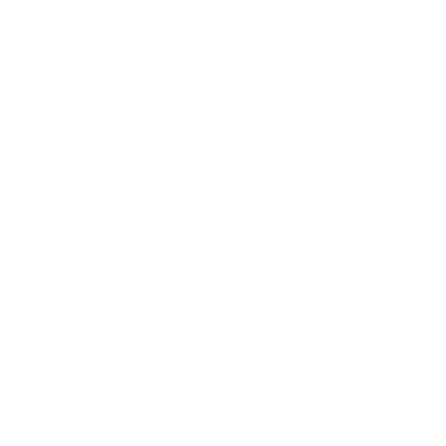

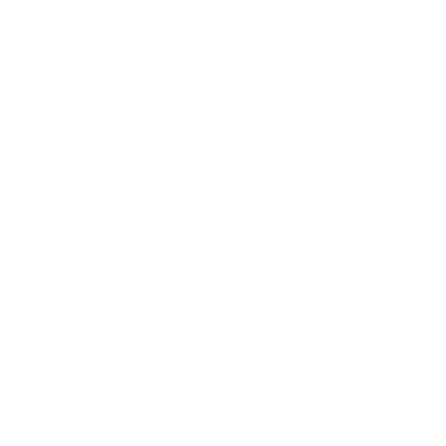

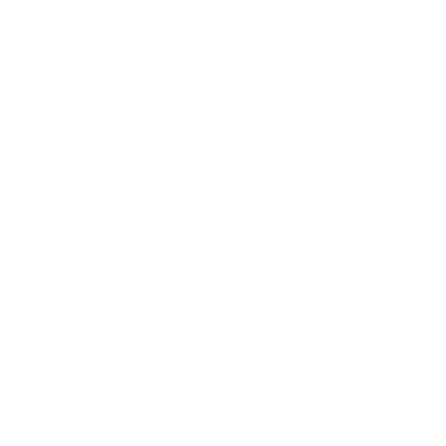

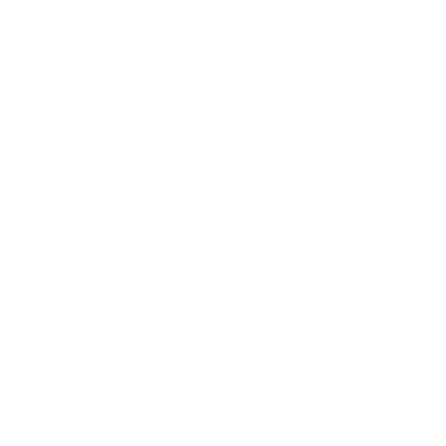

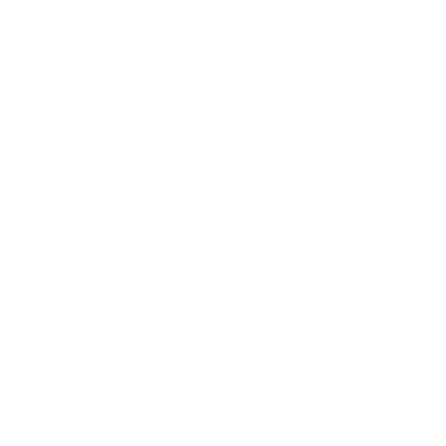

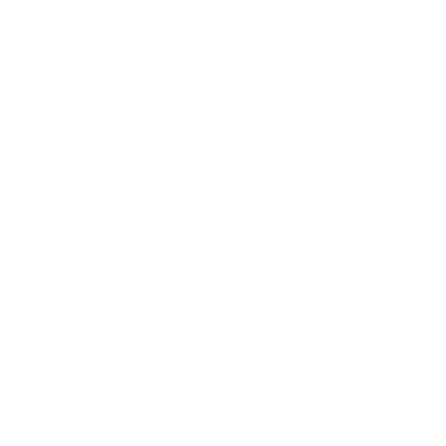

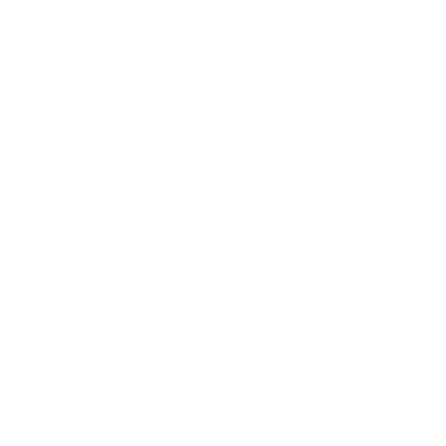

In [30]:
for imrec in these_image_recs:      
        s = imrec['sessionId']
        stroke_recs = coll.find({'$and': [{'sessionId':s}, 
                                          {'dataType':'stroke'},
                                          {'trialNum': imrec['trialNum']}]}).sort('time')  
        try:
        ## check to make sure that there is at least one stroke! 
            if stroke_recs.count()>0:

                ## some handy metadata for writing out the sketch PNG filename
                trial_num = imrec['trialNum']
                category = imrec['category']
                session_id = imrec['sessionId']
                kidName = imrec['kidName']
                print(kidName)

                ## now make an svg list!
                svg_list = make_svg_list(stroke_recs)

                ## now get me some verts and codes!
                Verts, Codes = get_verts_and_codes(svg_list)

                ## now render out your cumulative sketches and save out as pngs!
                render_and_save(Verts,
                                Codes,
                                line_width=5,
                                imsize=6,
                                canvas_size=809,
                                session_id=session_id,
                                kidName=kidName,
                                trial_num=trial_num,
                                category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass


In [31]:
# for i,s in enumerate(valid_sessions):  
#     image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
#     num_drawings = image_recs.count()
#     if num_drawings > 2 :
#         print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
#         ### now try looping through all images made during this session and render out
#         try:
#             image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
#             for imrec in image_recs:         
#                 if imrec['category'] in practice_categories: # only save practice category trials
#                     stroke_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, 
#                                                       {'sessionId':s}, 
#                                                       {'dataType':'stroke'},
#                                                       {'trialNum': imrec['trialNum']}]}).sort('time')  
#                     ## check to make sure that there is at least one stroke! 
#                     assert stroke_recs.count()>0

#                     ## some handy metadata for writing out the sketch PNG filename
#                     trial_num = stroke_recs[0]['trialNum']
#                     category = stroke_recs[0]['category']
#                     session_id = stroke_recs[0]['sessionId']
#                     age = stroke_recs[0]['age']

#                     ## now make an svg list!
#                     svg_list = make_svg_list(stroke_recs)

#                     ## now get me some verts and codes!
#                     Verts, Codes = get_verts_and_codes(svg_list)

#                     ## now render out your cumulative sketches and save out as pngs!
#                     render_and_save(Verts,
#                                     Codes,
#                                     line_width=5,
#                                     imsize=6,
#                                     canvas_size=809,
#                                     session_id=session_id,
#                                     age=age,
#                                     trial_num=trial_num,
#                                     category=category)

#         except Exception as e:
#             print 'Oops, something went wrong! Here is the error:'  
#             print e
#             pass
